In [1]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset, SuperclassDataset
from data_utils import *
from sampling import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils import mean_reciprocal_rank
import pickle
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97

LOG_FREQ = 10
method_list = ['random_data', 
               'random_data_informed', 
               'ts_informed']
DATASET_LIST = ['cifar100', 'svhn', '20newsgroup', 'dbpedia'] #'imagenet', 
output_dir = pathlib.Path("../output/confusion_matrix")

In [2]:
metric = 'confusion_matrix' # 'ece', 'confusion_matrix'
group_method = 'predicted_class'
pseudocount = 1
superclass = False #todo: superclass=true
cost_matrix = None
topk = 1

# load results and compute ground truth
ground_truth = {}
weight_k = {}
l2_error = {}
logp = {} # log likelihood of each estimated confusion matrix under dirichlet distribution

In [3]:
for dataset_name in DATASET_LIST:
    experiment_name = '%s_top%d_pseudocount%d' % (dataset_name, 1, 1)
    ground_truth[dataset_name] = pickle.load(open(output_dir / experiment_name / "ground_truth.pkl", "rb"))  
    l2_error[dataset_name] = pickle.load(open(output_dir / experiment_name / "l2_error.pkl", "rb"))  
    logp[dataset_name] = pickle.load(open(output_dir / experiment_name / "logp.pkl", "rb"))

# $L_2$

In [4]:
l2_error[dataset_name]

{'random_data': array([[3.97601036e-01, 1.33475558e-01, 6.63000423e-02, ...,
         3.71395010e-08, 3.71395010e-08, 3.71395011e-08],
        [3.97521444e-01, 6.57694300e-02, 3.69255176e-08, ...,
         3.71395010e-08, 3.71395010e-08, 3.71395011e-08],
        [3.97839865e-01, 2.65133732e-01, 6.62337157e-02, ...,
         3.71395010e-08, 3.71395010e-08, 3.71395011e-08],
        ...,
        [3.31738839e-01, 2.65332711e-01, 1.32918415e-01, ...,
         3.71395010e-08, 3.71395010e-08, 3.71395011e-08],
        [4.63144972e-01, 1.98488828e-01, 1.32281680e-01, ...,
         3.71395010e-08, 3.71395010e-08, 3.71395011e-08],
        [4.63595993e-01, 1.99244951e-01, 1.33037803e-01, ...,
         3.71395010e-08, 3.71395010e-08, 3.71395011e-08]]),
 'random_data_informed': array([[1.98622033e-05, 7.70867082e-06, 5.27174915e-06, ...,
         3.67662727e-08, 3.67663223e-08, 3.67664198e-08],
        [5.68812828e-05, 3.34782908e-05, 8.04501897e-06, ...,
         3.67663201e-08, 3.67663622e-08, 3.6

Text(0, 0.5, '$L_2$ Error')

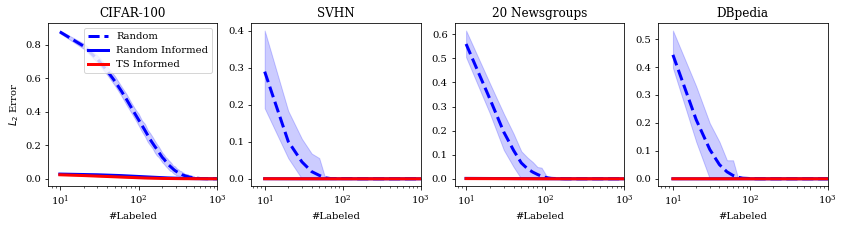

In [5]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,3),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = l2_error[dataset_name]['random_data'].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                 np.mean((l2_error[dataset_name][method_name]), axis=0)[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.125, axis=0)[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.875, axis=0)[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
    axes[i].set_xlim(0,1000)
    #axes[i].set_ylim(0,np.max(np.mean((l2_error[dataset_name]['random_data_informed']), axis=0)))
axes[0].legend(fontsize=10, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')

In [6]:
method_format = {'random_data': ('Random', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}
for i, dataset_name in enumerate(DATASET_LIST):
    print('\n',dataset_name)
    dataset = Dataset.load_from_text(dataset_name)
    dataset.group(group_method = group_method)
    num_params = dataset.num_groups ^ 2
    N_list = [20,50,100]
    for N in N_list:
        N = max(int(N//10)*10, 10)
        print("N, #params=(%d,%d) =======" % (N,num_params))
        for method_name in method_format:
            print('%s: %.4f' % (method_name, l2_error[dataset_name][method_name][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                 (l2_error[dataset_name]['scores'] + 1) ))


 cifar100
N, #params=(20,102) =======
random_data: 0.7288
random_data_informed: 0.0239
ts_informed: 0.0178
N, #params=(50,102) =======
random_data: 0.5356
random_data_informed: 0.0189
ts_informed: 0.0103
N, #params=(100,102) =======
random_data: 0.3237
random_data_informed: 0.0129
ts_informed: 0.0053

 svhn
N, #params=(20,8) =======
random_data: 0.1011
random_data_informed: 0.0001
ts_informed: 0.0001
N, #params=(50,8) =======
random_data: 0.0092
random_data_informed: 0.0000
ts_informed: 0.0000
N, #params=(100,8) =======
random_data: 0.0006
random_data_informed: 0.0000
ts_informed: 0.0000

 20newsgroup
N, #params=(20,22) =======
random_data: 0.3209
random_data_informed: 0.0011
ts_informed: 0.0004
N, #params=(50,22) =======
random_data: 0.0636
random_data_informed: 0.0004
ts_informed: 0.0001
N, #params=(100,22) =======
random_data: 0.0061
random_data_informed: 0.0001
ts_informed: 0.0000

 dbpedia
N, #params=(20,12) =======
random_data: 0.2112
random_data_informed: 0.0000
ts_informed: 0.

In [7]:
dataset_print= {
    'cifar100': 'CIFAR-100',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia'
}
dataset_list = ['cifar100','svhn', '20newsgroup','dbpedia']
method_format = {'random_data': ('Random', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}
Nlist = [10,100,500];

print('\\begin{tabular}{@{}ccccccccccccccccc@{}}')
print('\\toprule ')
for dataset in dataset_list:
    print('& \phantom{a} &  \multicolumn{3}{c}{%s}' % dataset_print[dataset])
print('\\\ ')
for dataset in dataset_list:
    print('& \phantom{a} &  N=%d & N=%d & N=%d' % tuple(Nlist))
print('\\\ ')
print('\cmidrule{3-5} \cmidrule{7-9} \cmidrule{11-13} \cmidrule{15-17}')

for method in method_format:
    method_name = method_format[method][0]
    print('\multicolumn{2}{c}{%15s}' % method_name, end = '')
    
    for dataset_name in dataset_list:
        for N in N_list:
            if dataset_name == 'dbpedia':
                val = l2_error[dataset_name][method][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                        l2_error[dataset_name]['scores']
            else:
                val = l2_error[dataset_name][method][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                        l2_error[dataset_name]['scores']
            print('& %4.1f  ' % (100 * val), end = '')
            
        if dataset_name != dataset_list[-1]:
            print('&', end = '')
    print('\\\\ \n', end = '');
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{@{}ccccccccccccccccc@{}}
\toprule 
& \phantom{a} &  \multicolumn{3}{c}{CIFAR-100}
& \phantom{a} &  \multicolumn{3}{c}{SVHN}
& \phantom{a} &  \multicolumn{3}{c}{20 Newsgroups}
& \phantom{a} &  \multicolumn{3}{c}{DBpedia}
\\ 
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
\\ 
\cmidrule{3-5} \cmidrule{7-9} \cmidrule{11-13} \cmidrule{15-17}
\multicolumn{2}{c}{         Random}& 915.0  & 672.4  & 406.4  && 7707.7  & 702.5  & 46.3  && 990.7  & 196.4  & 18.8  && 130757.2  & 15425.8  & 533.0  \\ 
\multicolumn{2}{c}{Random Informed}& 29.9  & 23.8  & 16.2  && 10.3  &  2.4  &  0.5  &&  3.4  &  1.3  &  0.3  && 14.4  &  3.9  &  0.9  \\ 
\multicolumn{2}{c}{    TS Informed}& 22.3  & 13.0  &  6.7  &&  4.5  &  1.0  &  0.2  &&  1.3  &  0.3  &  0.1  &&  2.5  &  0.6  &  0.1  \\ 
\bottomrule
\end{tabular}


In [8]:
dataset_print= {
    'cifar100': 'CIFAR-100',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia'
}
dataset_list = ['cifar100','svhn']
#dataset_list = ['20newsgroup','dbpedia']
method_format = {'random_data': ('Random Uninformative', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),}
N_list = [20, 50, 100];

print('\\begin{tabular}{@{}ccccccccc@{}}')
print('\\toprule ')
for dataset in dataset_list:
    print('& \phantom{a} &  \multicolumn{3}{c}{%s}' % dataset_print[dataset])
print('\\\ ')
print('\cmidrule{3-5} \cmidrule{7-9}')
for dataset in dataset_list:
    print('& \phantom{a} &  N=%d & N=%d & N=%d' % tuple(Nlist))
print('\\\ \\midrule')

for method in method_format:
    method_name = method_format[method][0]
    print('\multicolumn{2}{c}{%20s}' % method_name, end = '')
    
    for dataset_name in dataset_list:
        y = l2_error[dataset_name][method]#/l2_error[dataset_name]['scores']
        y = np.mean(y, axis=0)        
        for N in N_list:
            val = y[(N-LOG_FREQ)//LOG_FREQ]
            print('& %.3f  ' % val, end = '')
            
        if dataset_name != dataset_list[-1]:
            print('&', end = '')
    print('\\\\ \n', end = '');
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{@{}ccccccccc@{}}
\toprule 
& \phantom{a} &  \multicolumn{3}{c}{CIFAR-100}
& \phantom{a} &  \multicolumn{3}{c}{SVHN}
\\ 
\cmidrule{3-5} \cmidrule{7-9}
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
\\ \midrule
\multicolumn{2}{c}{Random Uninformative}& 0.792  & 0.582  & 0.352  && 0.101  & 0.009  & 0.001  \\ 
\multicolumn{2}{c}{  Random Informative}& 0.026  & 0.021  & 0.014  && 0.000  & 0.000  & 0.000  \\ 
\multicolumn{2}{c}{      TS Informative}& 0.019  & 0.011  & 0.006  && 0.000  & 0.000  & 0.000  \\ 
\bottomrule
\end{tabular}


In [9]:
num_groups_dict = {}
for dataset in DATASET_LIST:
    if group_method == 'score_equal_size':
        num_groups_dict[dataset] = 10
    if group_method == 'predicted_class':
        num_groups_dict[dataset] = NUM_CLASSES_DICT[dataset]

In [10]:
def print_narrow_table(dataset_list):
    
    N_list = [2, 5, 6, 7, 8,9, 10]
    method_format = {'random_data': ('UPrior', 'b', '^', '--'), 
                     #'ts_uniform': ('UPrior+TS', 'b', '^', '--'), 
                     'random_data_informed': ('IPrior', 'b', '^', '-'), 
                     'ts_informed': ('IPrior+TS', 'r', '+', '-'),}
    print('\\begin{tabular}{@{}ccccccc@{}}')
    print('\\toprule ')
    print('{N/K} & {N}', end = '')
    for method in method_format:
        print('& {%10s}' % method_format[method][0], end = '')
    print('\\\ ')
    
    for i, dataset_name in enumerate(dataset_list):
        print('\\midrule')
        for idx, N in enumerate(N_list):
            if idx == 0:
                name_string = DATASET_NAMES[dataset_name]
            else:
                name_string = ''
            vals = []
            for method in method_format:
                y = l2_error[dataset_name][method] #/l2_error[dataset_name]['scores']
                y = np.mean(y, axis=0) 
                K = num_groups_dict[dataset_name]
                num_samples = int(N*K)
                vals.append(y[(num_samples-LOG_FREQ)//LOG_FREQ])
            print('{%20s} & %d & %d & %.3f &%.3f &\\textbf{%.3f} \\\\ \n' % \
                  (name_string, N, num_samples, vals[0], vals[1], vals[2]), end = '')
    print('\\bottomrule')
    print('\\end{tabular}')

print_narrow_table(DATASET_LIST)

\begin{tabular}{@{}ccccccc@{}}
\toprule 
{N/K} & {N}& {    UPrior}& {    IPrior}& { IPrior+TS}\\ 
\midrule
{           CIFAR-100} & 2 & 200 & 0.127 &0.007 &\textbf{0.002} \\ 
{                    } & 5 & 500 & 0.006 &0.001 &\textbf{0.000} \\ 
{                    } & 6 & 600 & 0.002 &0.001 &\textbf{0.000} \\ 
{                    } & 7 & 700 & 0.000 &0.000 &\textbf{0.000} \\ 
{                    } & 8 & 800 & 0.000 &0.000 &\textbf{0.000} \\ 
{                    } & 9 & 900 & 0.000 &0.000 &\textbf{0.000} \\ 
{                    } & 10 & 1000 & 0.000 &0.000 &\textbf{0.000} \\ 
\midrule
{                SVHN} & 2 & 20 & 0.101 &0.000 &\textbf{0.000} \\ 
{                    } & 5 & 50 & 0.009 &0.000 &\textbf{0.000} \\ 
{                    } & 6 & 60 & 0.003 &0.000 &\textbf{0.000} \\ 
{                    } & 7 & 70 & 0.001 &0.000 &\textbf{0.000} \\ 
{                    } & 8 & 80 & 0.001 &0.000 &\textbf{0.000} \\ 
{                    } & 9 & 90 & 0.001 &0.000 &\textbf{0.000} \\ 
{   

In [11]:
print(y)

[1.34474417e-04 5.87644334e-05 3.09858972e-05 ... 1.44454783e-07
 1.44455320e-07 1.44455854e-07]


In [12]:
for method in method_format:
    method_name = method_format[method][0]
    for dataset_name in dataset_list:
        y = l2_error[dataset_name][method]/l2_error[dataset_name]['scores']
        y = np.mean(y, axis=0)        
        for N in N_list:
            val = y[(N-LOG_FREQ)//LOG_FREQ]
            print('====', method, dataset_name, (N-LOG_FREQ)//LOG_FREQ, val)
        print(y.max())

==== random_data cifar100 1 9.150158670086789
==== random_data cifar100 4 6.724033074393179
==== random_data cifar100 9 4.063774919137573
10.134681264237821
==== random_data svhn 1 77.07667776158279
==== random_data svhn 4 7.025049134725583
==== random_data svhn 9 0.4629163669883418
220.3402730579463
==== random_data_informed cifar100 1 0.29947222343288676
==== random_data_informed cifar100 4 0.2378547751946528
==== random_data_informed cifar100 9 0.1620897126087132
0.32562013682988655
==== random_data_informed svhn 1 0.10273933583726066
==== random_data_informed svhn 4 0.02375010406577087
==== random_data_informed svhn 9 0.004766488731644766
0.18977660036221633
==== ts_informed cifar100 1 0.222864439711687
==== ts_informed cifar100 4 0.1295842929893868
==== ts_informed cifar100 9 0.06666693922132512
0.2769610472047812
==== ts_informed svhn 1 0.04474601258323755
==== ts_informed svhn 4 0.00964194399150395
==== ts_informed svhn 9 0.0023827226017099183
0.10239516651043376


Text(0, 0.5, '$L_2$ Error')

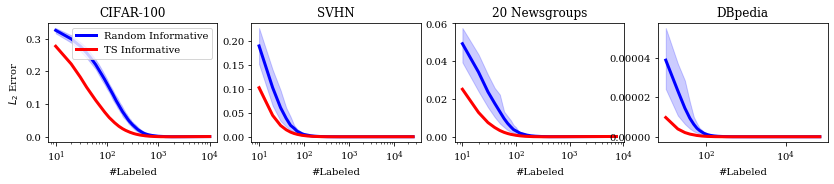

In [13]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 #'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,2.2),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = l2_error[dataset_name]['ts_informed'].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize] 
        if dataset_name == 'dbpedia':
            y = l2_error[dataset_name][method_name]
        else:
            y = l2_error[dataset_name][method_name]/ l2_error[dataset_name]['scores']
        eval_mean = np.mean(y, axis=0)
        eval_upper = np.quantile(y, 0.875, axis=0)
        eval_lower = np.quantile(y, 0.125, axis=0)
        axes[i].plot(xrange[idx], 
                 eval_mean[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         eval_lower[idx], 
                         eval_upper[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    #axes[i].set_yscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
axes[0].legend(fontsize=10, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')

In [14]:
l2_error[dataset_name]['diagonal'], l2_error[dataset_name]['ones']

(array(3.71395753e-08), array(0.92820006))

In [15]:
from scipy.stats import wilcoxon
for i, dataset_name in enumerate(['dbpedia']):
    for n in [2,5,10]:
        for (method_0, method_1) in [#('random_data', 'random_data_informed'),\
                                     # ('random_data_informed', 'ts_informed'),\
                                    ('random_data', 'ts_informed')]:
            num_samples = n * num_groups_dict[dataset_name]
            difference = (np.array(l2_error[dataset_name][method_0][:,(num_samples-LOG_FREQ)//LOG_FREQ]) - \
                                np.array(l2_error[dataset_name][method_1][:,(num_samples-LOG_FREQ)//LOG_FREQ])) \
                                        / l2_error[dataset_name]['scores']
            w, p = wilcoxon(difference)
            print(p)
            #print(difference)
            if p > 0.0000001:
                print(dataset_name, n, method_0, method_1)

3.7054666713541073e-165
1.629287182405704e-79
3.325859118934513e-165


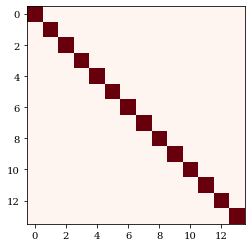

In [16]:
plt.imshow(np.log(ground_truth['dbpedia']['confusion_matrix']+ 1e-10).T, vmin=-10, vmax=0, cmap='Reds')

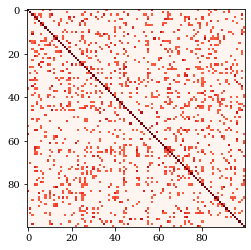

In [17]:
dataset = Dataset.load_from_text('cifar100')
dataset.group(group_method = 'predicted_class')

weight_k = dataset.weight_k
confusion_probs = dataset.confusion_probs()
confusion_probs = confusion_probs + np.ones(confusion_probs.shape) * 1e-6
confusion_probs = confusion_probs / confusion_probs.sum(axis=1)

plt.imshow(np.log(confusion_probs+ 1e-10).T, vmin=-10, vmax=0, cmap='Reds')